# Analysis Workflow of illumina reads from sample 25-japan.

#### this is a secondary mapping done against outbreak consensus sequence "cons_GI.2_outbreak2013k4.fa"

We will use paired reads from one sample. These were collected during a sapovirus outbreak in 2013
Let's start by aligning these reads to reference. The first step is creating an index to align the reads to. 

In [1]:
import os
os.chdir("/media/viro102/HD-ADU3/kte-data/sapo-ivar/test/outbreak_samples/GI.2/22_japan_2/")

In [2]:
%%bash
bwa index cons_GI.2_outbreak2013k4.fa
echo "reference indexed"

reference indexed


[bwa_index] Pack FASTA... 0.00 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 0.00 seconds elapse.
[bwa_index] Update BWT... 0.00 sec
[bwa_index] Pack forward-only FASTA... 0.00 sec
[bwa_index] Construct SA from BWT and Occ... 0.00 sec
[main] Version: 0.7.12-r1039
[main] CMD: bwa index cons_GI.2_outbreak2013k4.fa
[main] Real time: 0.589 sec; CPU: 0.009 sec


map reads to reference

In [3]:
%%bash
bwa mem -t 32 cons_GI.2_outbreak2013k4.fa  22_S5_L001_R1_001.fastq.gz 22_S5_L001_R2_001.fastq.gz | samtools view -b -F 4 -F 2048 | samtools sort -o 22_japan_GI.2_a.sorted.bam
samtools index 22_japan_GI.2_a.sorted.bam
"mapping completed"

mapping completed


[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 2333598 sequences (320000052 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (38, 1124617, 39, 36)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (304, 1119, 2680)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 7432)
[M::mem_pestat] mean and std.dev: (1639.71, 1606.75)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 9808)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (81, 125, 188)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 402)
[M::mem_pestat] mean and std.dev: (140.17, 77.77)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 509)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (46, 1059, 2696)
[M::mem_pestat] low a

Let's now trim off the primer sequences using ivar. In order to do this we need three files.BED file with primer coordinates. We will generate this by aligning the primer sequences to the reference sequence and then using bedtools to create the BED file. Aligned and sorted BAM file generate in the previous step.

In [8]:
%%bash

bwa mem -k 5 -T 16 cons_GI.2_outbreak2013k4.fa Primalprimers_SaV_GI.2_batch2_ok.fa  | samtools view -b -F 4 > Primalprimers_SaV_GI.2_batch2_ok.fa.bam

bedtools bamtobed -i Primalprimers_SaV_GI.2_batch2_ok.fa.bam > 22_japan_GI.2_primers.bed

 echo "bed file with primers locations on ref generated"

bed file with primers locations on ref generated


[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 68 sequences (1514 bp)...
[M::mem_process_seqs] Processed 68 reads in 0.011 CPU sec, 0.010 real sec
[main] Version: 0.7.12-r1039
[main] CMD: bwa mem -k 5 -T 16 cons_GI.2_outbreak2013k4.fa Primalprimers_SaV_GI.2_batch2_ok.fa
[main] Real time: 0.013 sec; CPU: 0.014 sec


We will now use BED file into ivar to trim primer sequences
Note that this BED file has to be generated only once per reference sequence.

In [10]:
%%bash
ivar trim -b 22_japan_GI.2_primers.bed -p 22_japan_GI.2.trimmed -i 22_japan_GI.2_a.sorted.bam

echo "primers trimming complete"

Number of references: 1
Reference Name: cons_GI.2_outbreak2013k4
Reference Length: 7442
Using Region: cons_GI.2_outbreak2013k4
Sorted By Coordinate
Sorted By Query Name
Processed 1000000 reads ... 
Processed 2000000 reads ... 
Results: 
Trimmed primers from 705302 reads.
122462 reads were shortened below the minimum length of 30 bp and were not writen to file.
1941039 reads that started outside of primer regions were not written to file.
primers trimming complete


[E::idx_find_and_load] Could not retrieve index file for '22_japan_rem_GI.1_a.sorted.bam'


let us sort and index trimmed BAM file.


In [11]:
%%bash
samtools sort -o 22_japan_GI.2.trimmed.sorted.bam 22_japan_GI.2.trimmed.bam ; samtools index 22_japan_GI.2.trimmed.sorted.bam
tput setaf 1 echo "Sorted and indexed trimmed BAM file"

trimmed BAM file Sorted and indexed


In [ ]:
#Let's quicky take a look at the depth of the trimmed vs untrimmed BAM file. We'll extract the depth using the samtools depth command.


In [12]:
%%bash
mkdir depth
samtools depth -a 22_japan_GI.2.trimmed.sorted.bam > depth/22_japan_GI.2.trimmed.sorted.bam.depth ; samtools depth -a 22_japan_GI.2_a.sorted.bam > depth/22_japan_GI.2.sorted.bam.depth
tput setaf 1 echo "please plot the depth per position"


please plot the depth per position


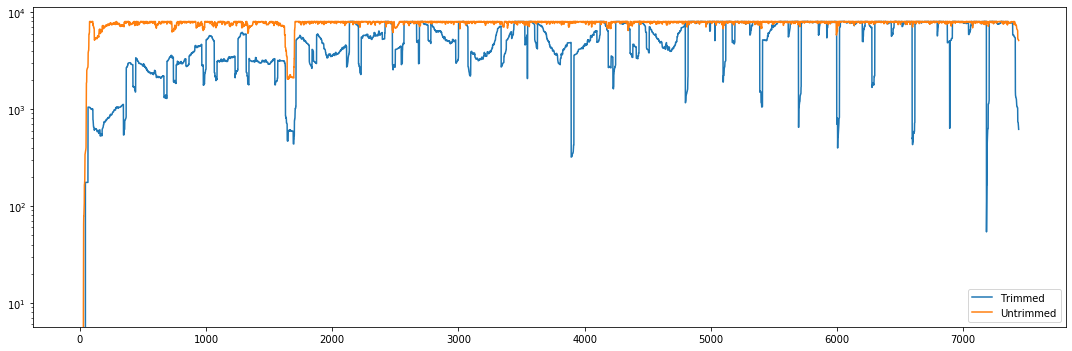

In [20]:
import os
os.chdir("/media/viro102/HD-ADU3/kte-data/sapo-ivar/test/outbreak_samples/GI.2/22_japan_2/depth")
import pandas as pd 
import matplotlib.pyplot as plt
df_trimmed = pd.read_csv("22_japan_GI.2.trimmed.sorted.bam.depth", sep = "\t", names = ["Ref", "Pos","depth_tr"])
df_untrimmed = pd.read_csv("22_japan_GI.2.sorted.bam.depth", sep = "\t", names = ["Ref", "Pos","depth_untr"])
ax = df_trimmed["depth_tr"].plot(logy=True, label = "Trimmed", figsize = (15,5))
df_untrimmed["depth_untr"].plot(logy=True, ax = ax, label ="Untrimmed")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
os.chdir("/media/viro102/HD-ADU3/kte-data/sapo-ivar/test/outbreak_samples/GI.2/22_japan_2/")


Now, we need to identify primer sequences that might have a mismatch with the consensus sequence to ensure that we remove reads from any amplicon that might bias the iSNV frequency due to varying primer binding effeciency"
To do this, we should : 
-Call consensus on merged BAM file.
-align primer sequences to consensus after creating a bwa index from the consensus sequence called.

In [17]:
%%bash

samtools mpileup -A -d 0 -Q 0 22_japan_GI.2.trimmed.sorted.bam  | ivar consensus -p 22_japan_GI.2.consensus
echo "consensus called on merged BAM file."
bwa index -p 22_japan_GI.2.consensus 22_japan_GI.2.consensus.fa

bwa mem -k 5 -T 16 22_japan_GI.2.consensus Primalprimers_SaV_GI.2_batch2_ok.fa  | samtools view -bS -F 4 | samtools sort -o 22_japan_GI.2_primers_consensus.bam

tput setaf 1 echo "primers mapped to consensus"

Minimum Quality: 20
Threshold: 0
Minimum depth:  
Regions with depth less than minimum depth covered by: -
consensus called on merged BAM file.


[mpileup] 1 samples in 1 input files
[mpileup] Max depth set to maximum value (2147483647)
[bwa_index] Pack FASTA... 0.00 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 0.00 seconds elapse.
[bwa_index] Update BWT... 0.00 sec
[bwa_index] Pack forward-only FASTA... 0.00 sec
[bwa_index] Construct SA from BWT and Occ... 0.00 sec
[main] Version: 0.7.12-r1039
[main] CMD: bwa index -p 22_japan_rem_GI.1.consensus 22_japan_rem_GI.1.consensus.fa
[main] Real time: 0.518 sec; CPU: 0.009 sec
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[E::main_mem] fail to open file `Primalprimers_SaVGI.1_batch2_ok.fa'.


Let's now call iSNVs on this BAM file at a minimum threshold of 3% and the default minimum quality threshold of 20

In [ ]:
%%bash
samtools mpileup -A -d 0 --reference 22_japan_GI.2.consensus.fa -Q 0 22_japan_GI.2_primers_consensus.bam | ivar variants -p 22_japan_GI.2_primers_consensus_1 -t 0.03


Echo "Let's now get the indices of primers with mismtaches and their respective pairs. To get the pair information, we need a tsv file with two columns to represent the pairs of primers. This file is in pair_information.tsv"

In [18]:
%%bash
bedtools bamtobed -i 22_japan_GI.2_primers_consensus.bam > 22_japan_GI.2_primers_consensus.bam.bed ; ivar getmasked -i 22_japan_GI.2_primers_consensus_1.tsv -b 22_japan_GI.2_primers_consensus.bam.bed -f Primal-primers_SaVGI.2pairs_ok.tsv -p primer_mismatchers_indices


tput setaf 1 echo "you got the indices of primers with mismtaches and their respective pairs"


you got the indices of primers with mismtaches and their respective pairs


let us remove reads from mismatched primers(Masking). Those reads are associated with false iSNPs. After that, let us compute depth in masked and unmasked files

In [19]:
%%bash

ivar removereads -i 22_japan_GI.2.trimmed.sorted.bam -p 22_japan_GI.2.bad_are_masked.bam -t primer_mismatchers_indices.txt -b 22_japan_GI.2_primers.bed

tput setaf 1 echo "you removed reads from mismatched primers"
samtools sort -o 22_japan_GI.2.bad_are_masked.sorted.bam 22_japan_GI.2.bad_are_masked.bam 
samtools depth -a 22_japan_GI.2.bad_are_masked.sorted.bam > depth/22_japan_GI.2.bad_are_masked.sorted.depth

Writing to 22_japan_rem_GI.1.bad_are_masked.bam
Number of references: 1
Reference Name: cons_GI.2_outbreak2013k4
Reference Length: 7442
Using Region: cons_GI.2_outbreak2013k4
Sorted By Coordinate
Results:
0 reads were removed.


Let us now plot depth for the masked and unmasked samples

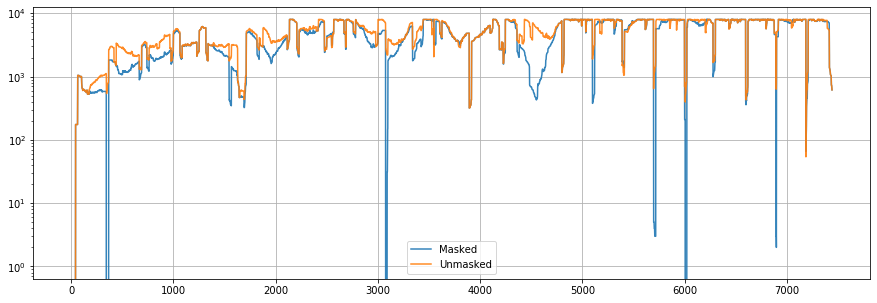

In [22]:
os.chdir("/media/viro102/HD-ADU3/kte-data/sapo-ivar/test/outbreak_samples/GI.2/22_japan_2/depth")
import pandas as pd
import matplotlib.pyplot as plt
df_unmasked = pd.read_csv("22_japan_GI.2.trimmed.sorted.bam.depth", sep = "\t", names = ["Ref", "Pos", "depth_unmask"])
df_masked = pd.read_csv("22_japan_GI.2.bad_are_masked.sorted.depth", sep = "\t", names = ["Ref", "Pos", "depth_mask"])

ax = df_masked["depth_mask"].plot(logy=True, label = "Masked", figsize = (15,5), alpha = 0.9)
df_unmasked["depth_unmask"].plot(logy=True, ax = ax, label ="Unmasked", alpha=0.9)
plt.legend()
plt.grid()
plt.show()

Let's now call iSNVs from the BAMS without reads from the masked amplicons as well as the amino acid consequence of each mutation

In [23]:
os.chdir("/media/viro102/HD-ADU3/kte-data/sapo-ivar/test/outbreak_samples/GI.2/22_japan_2/")


In [32]:
%%bash

samtools mpileup -A -d 0 --reference cons_GI.2_outbreak2013k4.fa -Q 0 22_japan_GI.2.bad_are_masked.sorted.bam | ivar variants -p 22_japan_GI.2_final -t 0.03 -r cons_GI.2_outbreak2013k4.fa -g cons_GI.2_outbreak2013k4.gff ; tput setaf 1 echo "analysis is completed"
tput setaf 1 echo "please exclude variants with depth <400 and count iSNV"

analysis is completed
please exclude variants with depth <400 and count iSNV


[mpileup] 1 samples in 1 input files
[mpileup] Max depth set to maximum value (2147483647)


show position of called variants

In [29]:
os.chdir("/media/viro102/HD-ADU3/kte-data/sapo-ivar/test/outbreak_samples/GI.2/22_japan_2/")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
rep_a = pd.read_csv("22_japan_GI.2_final.tsv", sep="\t")
rep_a["AA_csq"] = np.where(rep_a["REF_AA"] == rep_a["ALT_AA"], "Synonymous", "Non-Synonymous")
rep_a.head()

,REGION,POS,REF,ALT,REF_DP,REF_RV,REF_QUAL,ALT_DP,ALT_RV,ALT_QUAL,ALT_FREQ,TOTAL_DP,PVAL,PASS,GFF_FEATURE,REF_CODON,REF_AA,ALT_CODON,ALT_AA,AA_csq
0,cons_GI.2_outbreak2013k4,972,C,T,2149,2042,37,303,292,34,0.123573,2452,6.962400e-96,True,NaN,GGC,G,GGT,G,Synonymous
1,cons_GI.2_outbreak2013k4,3543,G,A,9920,7694,42,856,840,25,0.079428,10777,2.451030e-166,True,NaN,GTG,V,GTA,V,Synonymous
2,cons_GI.2_outbreak2013k4,4962,C,T,17756,14999,41,1179,981,40,0.062246,18941,0.000000e+00,True,NaN,GCC,A,GCT,A,Synonymous
3,cons_GI.2_outbreak2013k4,5175,C,T,11306,2005,39,1046,21,38,0.084655,12356,7.040980e-315,True,NaN,TCC,S,TCT,S,Synonymous
4,cons_GI.2_outbreak2013k4,5302,C,A,10798,9743,39,595,466,39,0.052207,11397,7.510120e-169,True,NaN,CTG,L,ATG,M,Non-Synonymous


In [30]:
 rep_b = rep_a[rep_a['TOTAL_DP'] >= 400]
rep_b

,REGION,POS,REF,ALT,REF_DP,REF_RV,REF_QUAL,ALT_DP,ALT_RV,ALT_QUAL,ALT_FREQ,TOTAL_DP,PVAL,PASS,GFF_FEATURE,REF_CODON,REF_AA,ALT_CODON,ALT_AA,AA_csq
0,cons_GI.2_outbreak2013k4,972,C,T,2149,2042,37,303,292,34,0.123573,2452,6.962400e-96,True,NaN,GGC,G,GGT,G,Synonymous
1,cons_GI.2_outbreak2013k4,3543,G,A,9920,7694,42,856,840,25,0.079428,10777,2.451030e-166,True,NaN,GTG,V,GTA,V,Synonymous
2,cons_GI.2_outbreak2013k4,4962,C,T,17756,14999,41,1179,981,40,0.062246,18941,0.000000e+00,True,NaN,GCC,A,GCT,A,Synonymous
3,cons_GI.2_outbreak2013k4,5175,C,T,11306,2005,39,1046,21,38,0.084655,12356,7.040980e-315,True,NaN,TCC,S,TCT,S,Synonymous
4,cons_GI.2_outbreak2013k4,5302,C,A,10798,9743,39,595,466,39,0.052207,11397,7.510120e-169,True,NaN,CTG,L,ATG,M,Non-Synonymous
5,cons_GI.2_outbreak2013k4,6220,A,G,7377,5476,39,1509,1485,37,0.169799,8887,0.000000e+00,True,NaN,ATC,I,GTC,V,Non-Synonymous


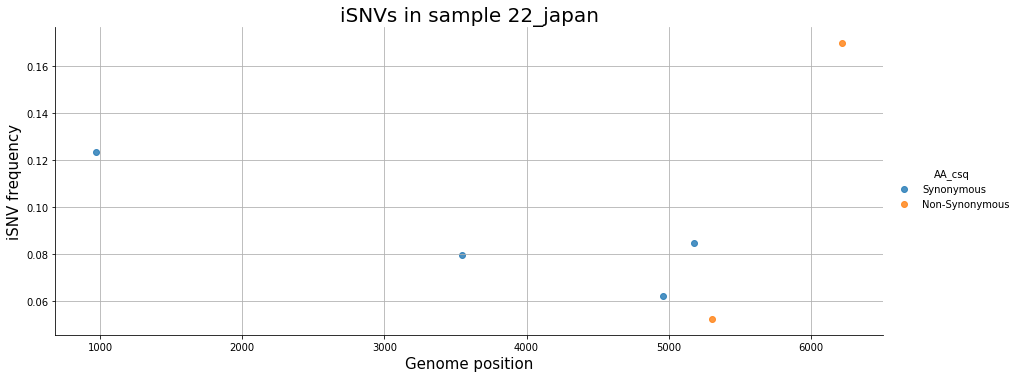

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
rep_b=rep_a[rep_a['TOTAL_DP'] >= 400]
sns.lmplot( x="POS", y="ALT_FREQ", data=rep_b, fit_reg=False, hue='AA_csq',aspect=20/8, 
           legend=True, legend_out=True)
plt.xlabel('Genome position', fontsize=15)
plt.ylabel('iSNV frequency', fontsize=15)
plt.title('iSNVs in sample 22_japan', fontsize=20)
plt.grid(axis="both")
plt.show()

In [34]:
# let us filter snps in non structural region [1-5099]
print("snps in non structural region")
print((rep_b[(rep_b['POS'] > 3610) & (rep_b['POS'] < 5099)]).shape)
# let us filter snps in complete capsid[5010-6800]
print("snps in capsid")
print((rep_b[(rep_b['POS'] > 5100) & (rep_b['POS'] < 7350)]).shape)

snps in non structural region
(1, 20)
snps in capsid
(3, 20)


In [38]:
# what percentage of this masked genome (without reads from mismached primers) has depth >400 ? 
os.chdir("/media/viro102/HD-ADU3/kte-data/sapo-ivar/test/outbreak_samples/GI.2/22_japan_2/depth")
df_masked = pd.read_csv("22_japan_GI.2.bad_are_masked.sorted.depth", sep = "\t", names = ["Ref", "Pos", "depth_mask"])
df_masked['400cov'] = np.where(df_masked['depth_mask']>=400, 'yes', 'no')
df_masked['100cov'] = np.where(df_masked['depth_mask']>=100, 'yes', 'no')
df_masked.head()

,Ref,Pos,depth_mask,400cov,100cov
0,cons_GI.2_outbreak2013k4,1,0,no,no
1,cons_GI.2_outbreak2013k4,2,0,no,no
2,cons_GI.2_outbreak2013k4,3,0,no,no
3,cons_GI.2_outbreak2013k4,4,0,no,no
4,cons_GI.2_outbreak2013k4,5,0,no,no


In [39]:
# What proportion of the genome is has a depth of coverage of at least >100 reads, >400 (Breadth ofcoverage)
my_tab1 = pd.crosstab(index=df_masked["100cov"],  # Make a crosstab
                              columns="Breadth 100coverage")      # Name the count column
my_tab2 = pd.crosstab(index=df_masked["400cov"],  # Make a crosstab
                              columns="Beadth above 400coverage")      # Name the count column
shape=df_masked.shape
print(shape)
print(my_tab1); print(my_tab2)

(7442, 5)
col_0   Breadth 100coverage
100cov                     
no                      128
yes                    7314
col_0   Beadth above 400coverage
400cov                          
no                           210
yes                         7232


In [41]:
7232/7442 * 100 # proportion of genome covered >400

97.1781779091642

In [40]:
7314/7442 * 100 # proportion of genome covered >100

98.28003224939532